In [1]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, AutoTokenizer,Qwen2_5_VLForConditionalGeneration, Qwen2_5_VLProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from datasets import load_from_disk, load_dataset
from transformers import TrainingArguments, Trainer
from pathlib import Path
from qwen_vl_utils import process_vision_info
import pandas as pd
from PIL import Image
import os
from trl import SFTConfig, SFTTrainer



C:\Users\Arbnor\Desktop\BA\BA\Bachelor_Arbeit_VQA\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-04-06 11:43:10,547] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


RuntimeError: Failed to import transformers.models.qwen2_5_vl.modeling_qwen2_5_vl because of the following error (look up to see its traceback):
CUDA_HOME does not exist, unable to compile CUDA op(s)

In [35]:
!pip3 install bitsandbytes peft trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 7.6 MB/s eta 0:00:00:00:01


In [2]:
!pip install git+https://github.com/huggingface/transformers accelerate




  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-eqzgs9cp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-eqzgs9cp
  Resolved https://github.com/huggingface/transformers to commit 348f3285c5114159d2ff4933b4b8ae36866d01a7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.51.0.dev0-py3-none-any.whl size=11069858 sha256=496a65a6ed637fc642452cab5ca607eb68280324745a64c32a021494f9df1d37
  Stored in directory: /tmp/pip-ephem-wheel-cache-pfd9vajd/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


In [3]:
pip install qwen-vl-utils[decord]==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.8/38.8 MB 48.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 104.1 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [63]:
os.environ["WANDB_DISABLED"] = "true"
import warnings
warnings.filterwarnings("ignore")



In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [65]:
device

'cuda'

In [67]:
MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"
EPOCHS = 1
BATCH_SIZE = 1
GRADIENT_CHECKPOINTING = True #Tradeoff between memory efficenecy and compution time
USE_REENTRANT = False
OPTIM = "paged_adamw_32bit"
LEARNING_RATE = 2e-5
LOGGING_STEPS = 50
EVAL_STEPS = 50
SAVE_STEPS = 100
EVAL_STRATEGY = "steps"
SAVE_STRATEGY = "steps"
METRIC_FOR_BEST_MODEL = "eval_loss"
LOAD_BEST_MODEL_AT_END=True
MAX_GRAD_NORM = 1
WARMUP_STEPS = 0
DATASET_KWARGS={"skip_prepare_dataset": True}
REMOVE_UNUSED_COLUMNS = False
MAX_SEQ_LEN=128
NUM_STEPS = ( 283 // BATCH_SIZE) * EPOCHS
print(f"NUM_STEPS: {NUM_STEPS}")

NUM_STEPS: 283


In [68]:
system_message = """"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer."""

def format_data(sample):
    # Erwartet in jeder Sample-Zeile:
    #   {"image": <PIL.Image>, "question": <str>, "answer": <str>}
    return [
        {
            "role": "system",
            "content": [
                {"type": "text", "text": system_message}
            ],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"], 
                },
                {
                    "type": "text",
                    "text": sample["question"],
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": sample["answer"]}
            ],
        },
    ]



In [69]:
dataset = load_dataset("flaviagiammarino/path-vqa")

In [1]:
dataset = load_dataset("flaviagiammarino/path-vqa")
train_dataset = dataset["train"]
val_dataset = dataset["validation"]


NameError: name 'dataset' is not defined

In [70]:
train_dataset = dataset["train"].select(range(283))
val_dataset = dataset["validation"].select(range(25))

In [10]:
len(train_dataset)

100

In [11]:
print(train_dataset)

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 100
})


In [12]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=309x272>,
 'question': 'where are liver stem cells (oval cells) located?',
 'answer': 'in the canals of hering'}

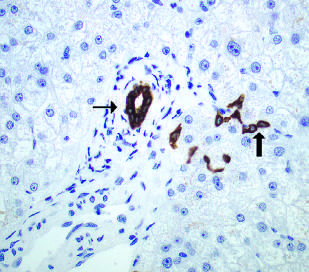

In [20]:
train_dataset[0]["image"]

In [71]:
train_dataset = [format_data(sample) for sample in train_dataset]
eval_dataset = [format_data(sample) for sample in val_dataset]

In [15]:
train_dataset[0]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': '"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=309x272>},
   {'type': 'text',
    'text': 'where are liver stem cells (oval cells) located?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text', 'text': 'in the canals of hering'}]}]

In [72]:
sample_data = train_dataset[0]
sample_question = train_dataset[0][1]["content"][1]["text"]
sample_answer = train_dataset[0][2]["content"][0]["text"]
sample_image =train_dataset[0][1]["content"][0]["image"]

In [57]:
sample_question

'where are liver stem cells (oval cells) located?'

In [58]:
sample_answer

'in the canals of hering'

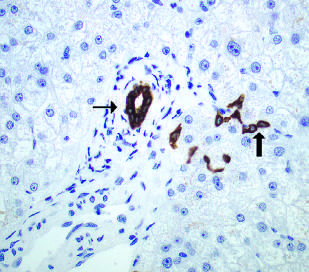

In [59]:
sample_image

In [73]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16  # Optional: torch.float16 als Fallback
    )
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(  # oder korrektes Modell
        MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto"
    )
else:
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        use_cache=False
    )

processor = Qwen2_5_VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [74]:
sample_data[0:2]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': '"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=309x272>},
   {'type': 'text',
    'text': 'where are liver stem cells (oval cells) located?'}]}]

In [75]:
def text_generator(sample_data):
    text = processor.apply_chat_template(
        sample_data[0:2], tokenize=False, add_generation_prompt=True
    )

    image_inputs = sample_data[1]["content"][0]["image"]

    inputs = processor(
        text=[text],
        images = image_inputs,
        return_tensors="pt"
    )

    inputs = inputs.to(device)

    generated_ids = model.generate(**inputs, max_new_tokens=MAX_SEQ_LEN)

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True
    )

    del inputs
    actual_answer = sample_data[2]["content"][0]["text"]
    return output_text[0], actual_answer

    print(f"Prompt: {text}")
    print("-"*30)


generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Generated Answer: system
"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.
user
where are liver stem cells (oval cells) located?
assistant
Liver stem cells (oval cells) are located in the liver sinusoids.
Actual Answer: in the canals of hering


In [76]:
text_generator(sample_data)

('system\n"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.\nuser\nwhere are liver stem cells (oval cells) located?\nassistant\nLiver stem cells (oval cells) are located in the liver sinusoids.',
 'in the canals of hering')

In [77]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=8,
    bias="none",
    target_modules= ["q_proj", "v_proj"],
    task_type="CAUSAL_LM"
)

print(f"Before adapter parameters: {model.num_parameters()}")
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

Before adapter parameters: 3754622976
trainable params: 1,843,200 || all params: 3,756,466,176 || trainable%: 0.0491


In [ ]:
!pip

In [78]:
training_args = SFTConfig(
    output_dir="./output",
    bf16=True,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    learning_rate=LEARNING_RATE,
    logging_steps=LOGGING_STEPS,
    eval_steps=EVAL_STEPS,
    eval_strategy=EVAL_STRATEGY,
    save_strategy=SAVE_STRATEGY,
    save_steps=SAVE_STEPS,
    metric_for_best_model=METRIC_FOR_BEST_MODEL,
    load_best_model_at_end=LOAD_BEST_MODEL_AT_END,
    max_grad_norm=MAX_GRAD_NORM,
    warmup_steps=WARMUP_STEPS,
    dataset_kwargs=DATASET_KWARGS,
    max_seq_length=MAX_SEQ_LEN,
    remove_unused_columns = REMOVE_UNUSED_COLUMNS,
    optim=OPTIM
    
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [79]:
collate_sample = [train_dataset[0], train_dataset[1]]

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]
    image_inputs = [example[1]["content"][0]["image"] for example in examples]

    batch = processor(
        text = texts, images = image_inputs, return_tensors="pt", padding=True
        
    )
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = batch["input_ids"]

    return batch

collated_data = collate_fn(collate_sample)
print(collated_data.keys())

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw', 'labels'])


In [80]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
    
    
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [81]:
print("-"*30)
print("Initial Evaluation")
metric = trainer.evaluate()
print(metric)
print("-"*30)

print("Training")
trainer.train()
print("-"*30)

------------------------------
Initial Evaluation


{'eval_loss': 14.954421043395996, 'eval_model_preparation_time': 0.0005, 'eval_runtime': 104.5645, 'eval_samples_per_second': 0.239, 'eval_steps_per_second': 0.239}
------------------------------
Training


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss,Model Preparation Time
50,15.234800,14.270899,0.000500
100,14.215500,12.964028,0.000500
150,12.357600,11.075445,0.000500
200,10.777200,9.629199,0.000500
250,9.482400,9.104522,0.000500


------------------------------


In [82]:
trainer.save_model(training_args.output_dir)

In [83]:
import gc
import time


def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 1.42 GB
GPU reserved memory: 3.21 GB


In [84]:
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16  # Optional: torch.float16 als Fallback
    )
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(  # oder korrektes Modell
        MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto",
        use_cache=True
    )
else:
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        use_cache=True
    )

processor = Qwen2_5_VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [85]:
print(f"Before adapter parameters: {model.num_parameters()}")
model.load_adapter("./output")
print(f"After adapter parameters: {model.num_parameters()}")

Before adapter parameters: 3754622976
After adapter parameters: 3756466176


In [86]:
generated_text, actual_answer = text_generator(sample_data)
print(f"Generated Answer: {generated_text}")
print(f"Actual Answer: {actual_answer}")

Generated Answer: system
"You are a medical pathology expert. Your task is to answer medical questions based solely on the visual information in the provided pathology image. Focus only on what is visible in the image — do not rely on prior medical knowledge, assumptions, or external information. Your responses should be short, factual, and medically precise, using appropriate terminology. Do not include any explanations, reasoning, or additional text. Use a consistent format, without punctuation, and avoid capitalisation unless medically required. Only return the exact answer.
user
where are liver stem cells (oval cells) located?
assistant
in oval cells
Actual Answer: in the canals of hering


In [57]:
import torch
print(torch.cuda.device_count())


2


In [58]:
import torch
torch.cuda.empty_cache()
